In [1]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
import quandl
import numpy as np
from datetime import date

Using TensorFlow backend.


In [2]:
quandl.ApiConfig.api_key = 'EnRH6kssPjP6yTE9zsg1'

In [3]:
start = date(2000,10,12)
end = date.today()
google_stock = pd.DataFrame(quandl.get("WIKI/GOOGL", start_date=start, end_date=end))
print(google_stock.shape)

(3424, 12)


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [7]:
google_stock.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,1092.57,1108.70,1087.21,1094.00,1990515.0,0.0,1.0,1092.57,1108.70,1087.21,1094.00,1990515.0
2018-03-22,1080.01,1083.92,1049.64,1053.15,3418154.0,0.0,1.0,1080.01,1083.92,1049.64,1053.15,3418154.0
2018-03-23,1051.37,1066.78,1024.87,1026.55,2413517.0,0.0,1.0,1051.37,1066.78,1024.87,1026.55,2413517.0
2018-03-26,1050.60,1059.27,1010.58,1054.09,3272409.0,0.0,1.0,1050.60,1059.27,1010.58,1054.09,3272409.0
2018-03-27,1063.90,1064.54,997.62,1006.94,2940957.0,0.0,1.0,1063.90,1064.54,997.62,1006.94,2940957.0


In [8]:
google_stock.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


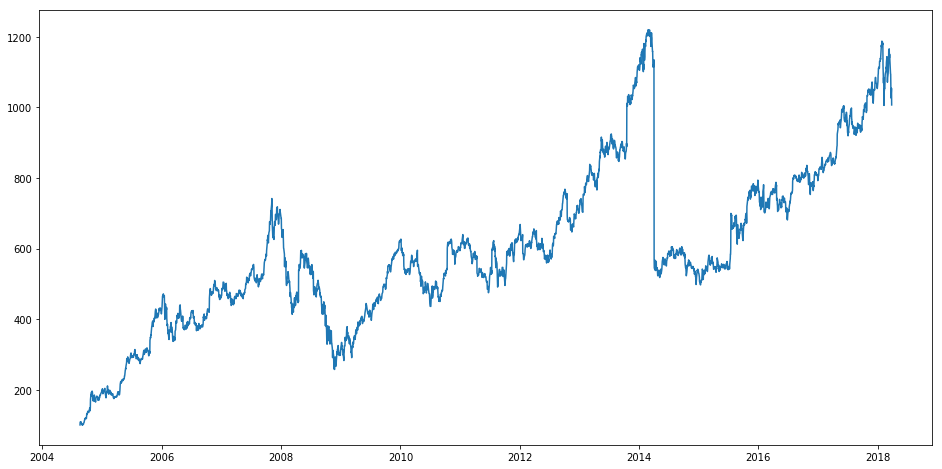

In [4]:
plt.figure(figsize=(16, 8))
plt.plot(google_stock['Close'])
plt.show()

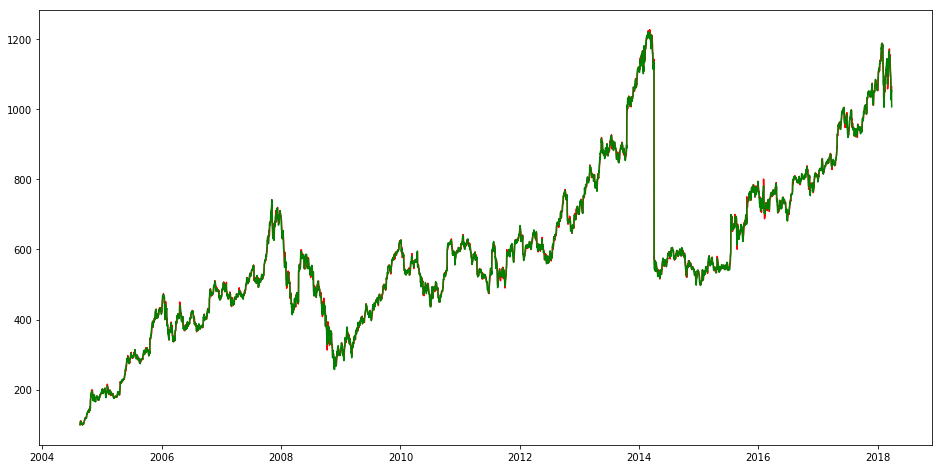

In [6]:
plt.figure(figsize=(16, 8))
plt.plot(google_stock['Open'],'r')
plt.plot(google_stock['Close'],'g')
plt.show()

In [9]:
# 时间点长度
time_stamp = 50

In [10]:
# 划分训练集与验证集
google_stock = google_stock[['Open', 'High', 'Low', 'Close', 'Volume']]  #  'Volume'
train = google_stock[0:2800 + time_stamp]
valid = google_stock[2800 - time_stamp:]

In [13]:
valid.shape

(674, 5)

In [29]:
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
x_train, y_train = [], []

In [30]:
# 训练集
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, 3:])

x_train, y_train = np.array(x_train), np.array(y_train)

In [32]:
y_train.shape

(2800, 2)

In [33]:
# 验证集
scaled_data = scaler.fit_transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, 3:])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [43]:
# 超参数
epochs = 3
batch_size = 16
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, 
               input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(LSTM(units=50))
model.add(Dense(2, input_dim=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=100, return_sequences=True, input_shape=(50, 5))`
  if __name__ == '__main__':


Epoch 1/3
2800/2800 [==============================] - 16s 6ms/step - loss: 0.0049
Epoch 2/3
2800/2800 [==============================] - 15s 5ms/step - loss: 0.0026
Epoch 3/3
2800/2800 [==============================] - 15s 5ms/step - loss: 0.0026


In [44]:
print(1)

1


In [50]:
scaler.fit_transform(pd.DataFrame(valid[['Close', 'Volume']].values))

array([[0.10826132, 0.50476368],
       [0.0735537 , 0.5537817 ],
       [0.07963971, 0.36785396],
       ...,
       [0.72002643, 0.29029483],
       [0.76791459, 0.42205084],
       [0.68592742, 0.37120534]])

In [52]:
closing_price = model.predict(x_valid)

In [53]:
scaler.fit_transform(pd.DataFrame(valid[['Close', 'Volume']].values))
# 反归一化
closing_price = scaler.inverse_transform(closing_price)

In [56]:
y_valid = scaler.inverse_transform(y_valid)

In [57]:
# print(y_valid)
# print(closing_price)
rms = np.sqrt(np.mean(np.power((y_valid - closing_price), 2)))
print(rms)
print(closing_price.shape)
print(y_valid.shape)

581424.7264056811
(624, 2)
(624, 2)


In [64]:
print(closing_price[:,0])

[ 646.7439   645.4119   646.8095   650.2497   654.5199   658.2953
  661.7152   665.0108   668.701    672.52594  676.5819   680.6835
  684.66205  687.5212   688.334    688.21576  692.8219   697.52814
  702.6209   708.0609   714.05664  720.0541   725.3997   730.4632
  735.59766  740.93604  745.61365  749.26044  751.78265  754.393
  756.274    756.39087  754.9712   753.3481   752.2423   752.15485
  753.95996  756.96674  759.5931   761.7337   763.5937   765.0702
  766.7674   769.23865  770.79474  771.6148   771.9656   771.5735
  770.5038   768.5961   765.5901   762.35205  760.49963  759.96783
  760.73126  761.18774  760.7743   760.6148   760.7965   761.2782
  762.95184  766.686    771.14307  774.7096   774.8242   773.2207
  770.166    765.557    759.92004  753.2852   748.0754   743.6454
  738.9432   733.43164  728.392    723.5235   720.33484  720.4536
  722.28906  724.2057   725.50745  727.7951   731.546    737.2109
  745.39294  750.78687  750.59076  745.63873  736.5394   727.2472
  719.84

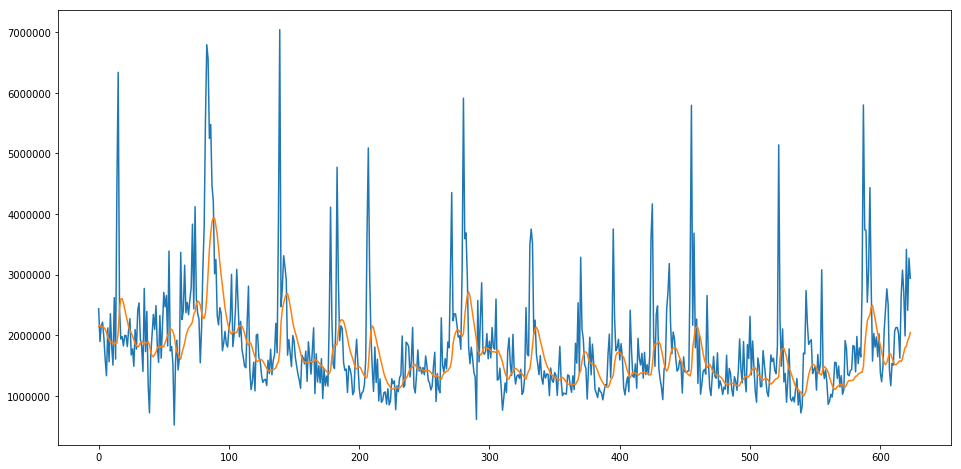

In [66]:
plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': closing_price[:,1],
    'Close': y_valid[:,1]
}
data_pd = pd.DataFrame(dict_data)

plt.plot(data_pd[['Close', 'Predictions']])
plt.show()